# Static Analyzer Evaluation

---

**Required R Packages:**

In [48]:
install.packages("pacman")
library(pacman)

Installing package into ‘/home/stephan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)



In [49]:
pacman::p_load(stringr, dplyr, tidyr, tidytext, ggplot2, ggtext, RColorBrewer)

---

In [50]:
theme_set(
    theme_bw(14) +
        theme(axis.text.x = element_markdown(),
              axis.text.y = element_markdown()) +
        theme(legend.margin = margin(0))
)

options(repr.plot.width = 10, repr.plot.height = 6)

In [51]:
options(
    warn = -1,
    stringsAsFactors = FALSE
)

In [52]:
analyzers = c(
    "flawfinder",
    "cppcheck",
    "infer",
    "codechecker",
    "codeql",
    "commsca"
)

analyzer_abbrevs = c("FLF", "CPC", "IFR", "CCH", "CQL", "CSA")

In [53]:
scenario_exprs = c(
    "Scenario 1 (S.1-1)" = expression("Scenario 1 (" * "S"["1-1"] * ")"),
    "Scenario 2 (S.1-2)" = expression("Scenario 2 (" * "S"["1-2"] * ")"),
    "Scenario 3 (S.2-1)" = expression("Scenario 3 (" * "S"["2-1"] * ")"),
    "Scenario 4 (S.2-2)" = expression("Scenario 4 (" * "S"["2-2"] * ")")
)

scenario_exprs_str = c(
    "Scenario 1 (S.1-1)" = as.character(scenario_exprs[1]),
    "Scenario 2 (S.1-2)" = as.character(scenario_exprs[2]),
    "Scenario 3 (S.2-1)" = as.character(scenario_exprs[3]),
    "Scenario 4 (S.2-2)" = as.character(scenario_exprs[4])
)

## Dataset Statistics

In [54]:
fct_stats_1 = read.csv("fct_stats_1.csv")

fct_stats_1[fct_stats_1 == "binutils"] = "Binutils"
fct_stats_1[fct_stats_1 == "ffmpeg"]   = "FFmpeg"
fct_stats_1[fct_stats_1 == "libpng"]   = "libpng"
fct_stats_1[fct_stats_1 == "libtiff"]  = "LibTIFF"
fct_stats_1[fct_stats_1 == "libxml2"]  = "Libxml2"
fct_stats_1[fct_stats_1 == "openssl"]  = "OpenSSL"
fct_stats_1[fct_stats_1 == "php"]      = "PHP"
fct_stats_1[fct_stats_1 == "poppler"]  = "Poppler"
fct_stats_1[fct_stats_1 == "sqlite3"]  = "SQLite3"

head(fct_stats_1)

,Target,File,Function,LOC,Vulnerable
,<chr>,<chr>,<chr>,<int>,<chr>
1,libpng,pngerror.c,png_error,5,False
2,libpng,pngerror.c,png_default_error,3,False
3,libpng,pngerror.c,png_longjmp,5,False
4,libpng,pngerror.c,png_safecat,9,False
5,libpng,pngerror.c,png_format_number,33,False
6,libpng,pngerror.c,png_benign_error,12,False


### Function LOC Distribution

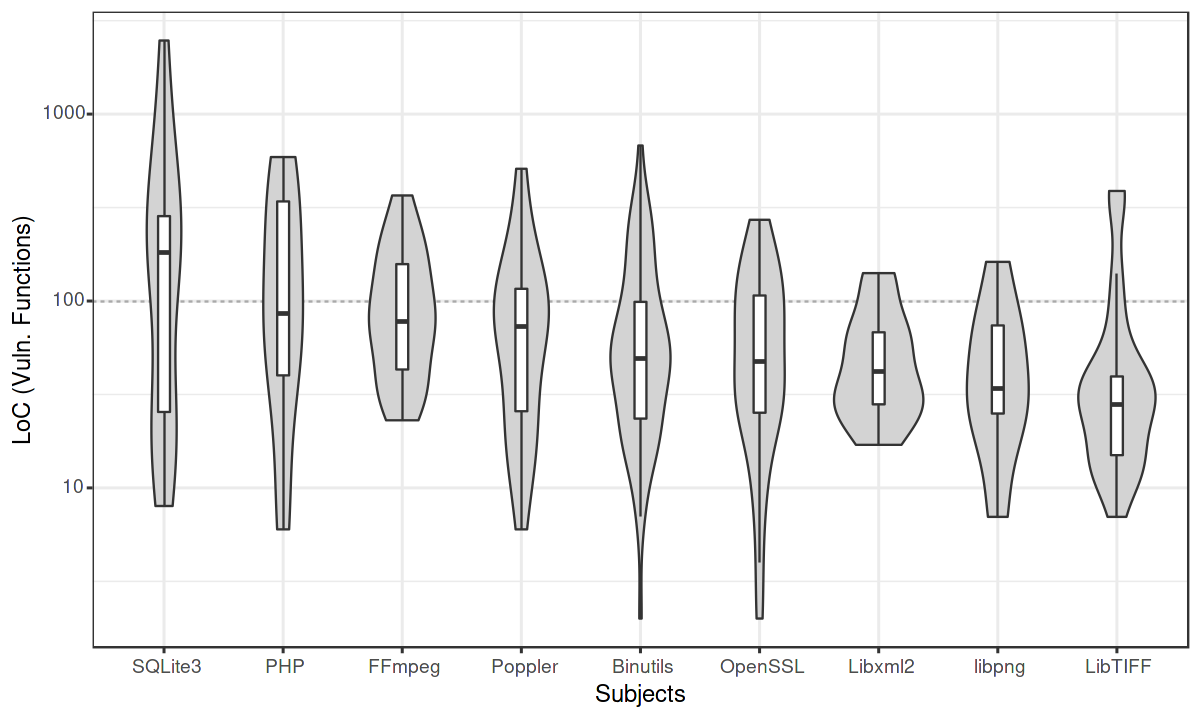

In [55]:
ggplot(filter(fct_stats_1, Vulnerable == "True"), aes(x = reorder(Target, -LOC, median), y = LOC)) +
    labs(x = "Subjects", y = "LoC (Vuln. Functions)") +
    geom_hline(yintercept = 100, size = 0.5, linetype = "dashed", color = "darkgrey") +
    geom_violin(fill = "lightgrey", width = 0.75) +
    geom_boxplot(width = 0.1, outlier.shape = NA) +
    scale_y_log10()

ggsave("fig1.pdf", width = 10, height = 6)

### Vuln.-Type (CWE) Distribution

In [56]:
cwe_distr = read.csv("cwe_distr.csv") %>%
    mutate(Label = paste0(LL_CWE_ID, " (", HL_CWE_ID, ")"),
           LL_CWE_Str = paste("CWE", LL_CWE_ID, sep = "-"),
           HL_CWE_Str = paste("CWE", HL_CWE_ID, sep = "-"))

head(cwe_distr)

,Target,LL_CWE_ID,HL_CWE_ID,N_CVEs,Label,LL_CWE_Str,HL_CWE_Str
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>
1,libpng,399,664,0,399 (664),CWE-399,CWE-664
2,libpng,681,664,0,681 (664),CWE-681,CWE-664
3,libpng,611,664,0,611 (664),CWE-611,CWE-664
4,libpng,416,664,1,416 (664),CWE-416,CWE-664
5,libpng,20,707,0,20 (707),CWE-20,CWE-707
6,libpng,835,691,0,835 (691),CWE-835,CWE-691


In [57]:
cwe_distr %>% group_by(HL_CWE_Str) %>% summarise(Sum.N_CVEs = sum(N_CVEs)) %>% arrange(desc(Sum.N_CVEs))

HL_CWE_Str,Sum.N_CVEs
<chr>,<int>
CWE-664,117
CWE-703,29
CWE-682,27
CWE-707,12
CWE-691,7


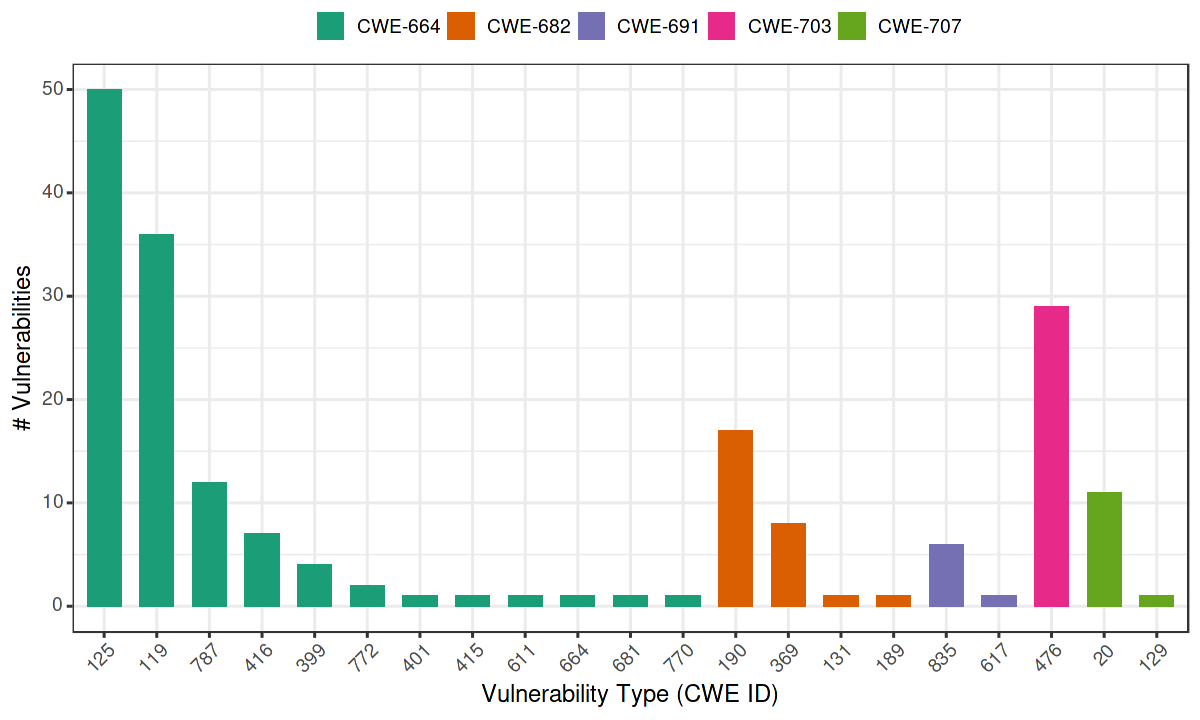

In [58]:
ggplot(cwe_distr, aes(x = reorder(reorder(factor(LL_CWE_ID), -N_CVEs), HL_CWE_ID), y = N_CVEs, fill = HL_CWE_Str)) +
    labs(x = "Vulnerability Type (CWE ID)", y = "# Vulnerabilities") +
    geom_bar(stat = "identity", width = 0.65) +
    scale_fill_brewer(palette = "Dark2") +
    theme(legend.position = "top", legend.title = element_blank()) +
    theme(axis.text.x  = element_markdown(angle = 45, vjust = 1, hjust = 1))

ggsave("fig2.pdf", width = 10, height = 6)

## Evaluation

We evaluate the vulnerability detection capabilities of the static code analyzers w.r.t. ***four different scenarios***:

- `Scenario 1 (S.1-1):` A vulnerability is considered detected if at least one affected function was marked by the static analyzer, regardless of the issued vulnerability class.

- `Scenario 2 (S.1-2):` A vulnerability is considered detected if at least one affected function was marked by the static analyzer together with the correct vulnerability class.

- `Scenario 3 (S.2-1):` A vulnerability is considered detected if all affected functions were marked by the static analyzer, regardless of the issued vulnerability class.

- `Scenario 4 (S.2-2):` A vulnerability is considered detected if all affected functions were marked by the static analyzer together with the correct vulnerability class.

In [59]:
sca_data_1 = read.csv("sca_data_1.csv") %>%
    mutate(Comb_Length   = lengths(str_split(Comb_Token, "-", simplify = FALSE)),
           Comb_Token_MD = gsub("CSA", "**CSA**", Comb_Token)) %>%
    mutate(Detection_Ratio = ifelse(N_All_CVEs == 0, 0, N_Detected_CVEs / N_All_CVEs))

sca_data_1[sca_data_1 == "binutils"] = "Binutils"
sca_data_1[sca_data_1 == "ffmpeg"]   = "FFmpeg"
sca_data_1[sca_data_1 == "libpng"]   = "libpng"
sca_data_1[sca_data_1 == "libtiff"]  = "LibTIFF"
sca_data_1[sca_data_1 == "libxml2"]  = "Libxml2"
sca_data_1[sca_data_1 == "openssl"]  = "OpenSSL"
sca_data_1[sca_data_1 == "php"]      = "PHP"
sca_data_1[sca_data_1 == "poppler"]  = "Poppler"
sca_data_1[sca_data_1 == "sqlite3"]  = "SQLite3"

head(sca_data_1)

,Analyzer_Comb,Comb_Token,Target,Scenario,N_Detected_CVEs,N_All_CVEs,Comb_Length,Comb_Token_MD,Detection_Ratio
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>
1,flawfinder,FLF,libpng,Scenario 1 (S.1-1),3,7,1,FLF,0.42857143
2,flawfinder,FLF,libpng,Scenario 2 (S.1-2),2,7,1,FLF,0.28571429
3,flawfinder,FLF,libpng,Scenario 3 (S.2-1),1,7,1,FLF,0.14285714
4,flawfinder,FLF,libpng,Scenario 4 (S.2-2),1,7,1,FLF,0.14285714
5,flawfinder,FLF,LibTIFF,Scenario 1 (S.1-1),1,13,1,FLF,0.07692308
6,flawfinder,FLF,LibTIFF,Scenario 2 (S.1-2),1,13,1,FLF,0.07692308


### RQ.1: Static Analyzer Effectiveness

In [60]:
sca_data_1a = sca_data_1 %>%
    filter(is.element(Analyzer_Comb, analyzers)) %>%
    mutate(Detection_Ratio = ifelse(N_All_CVEs == 0, 0, N_Detected_CVEs / N_All_CVEs))

sca_data_1a_s1 = sca_data_1a %>% filter(Scenario %in% c("Scenario 1 (S.1-1)"))
sca_data_1a_s2 = sca_data_1a %>% filter(Scenario %in% c("Scenario 2 (S.1-2)"))
sca_data_1a_s3 = sca_data_1a %>% filter(Scenario %in% c("Scenario 3 (S.2-1)"))
sca_data_1a_s4 = sca_data_1a %>% filter(Scenario %in% c("Scenario 4 (S.2-2)"))

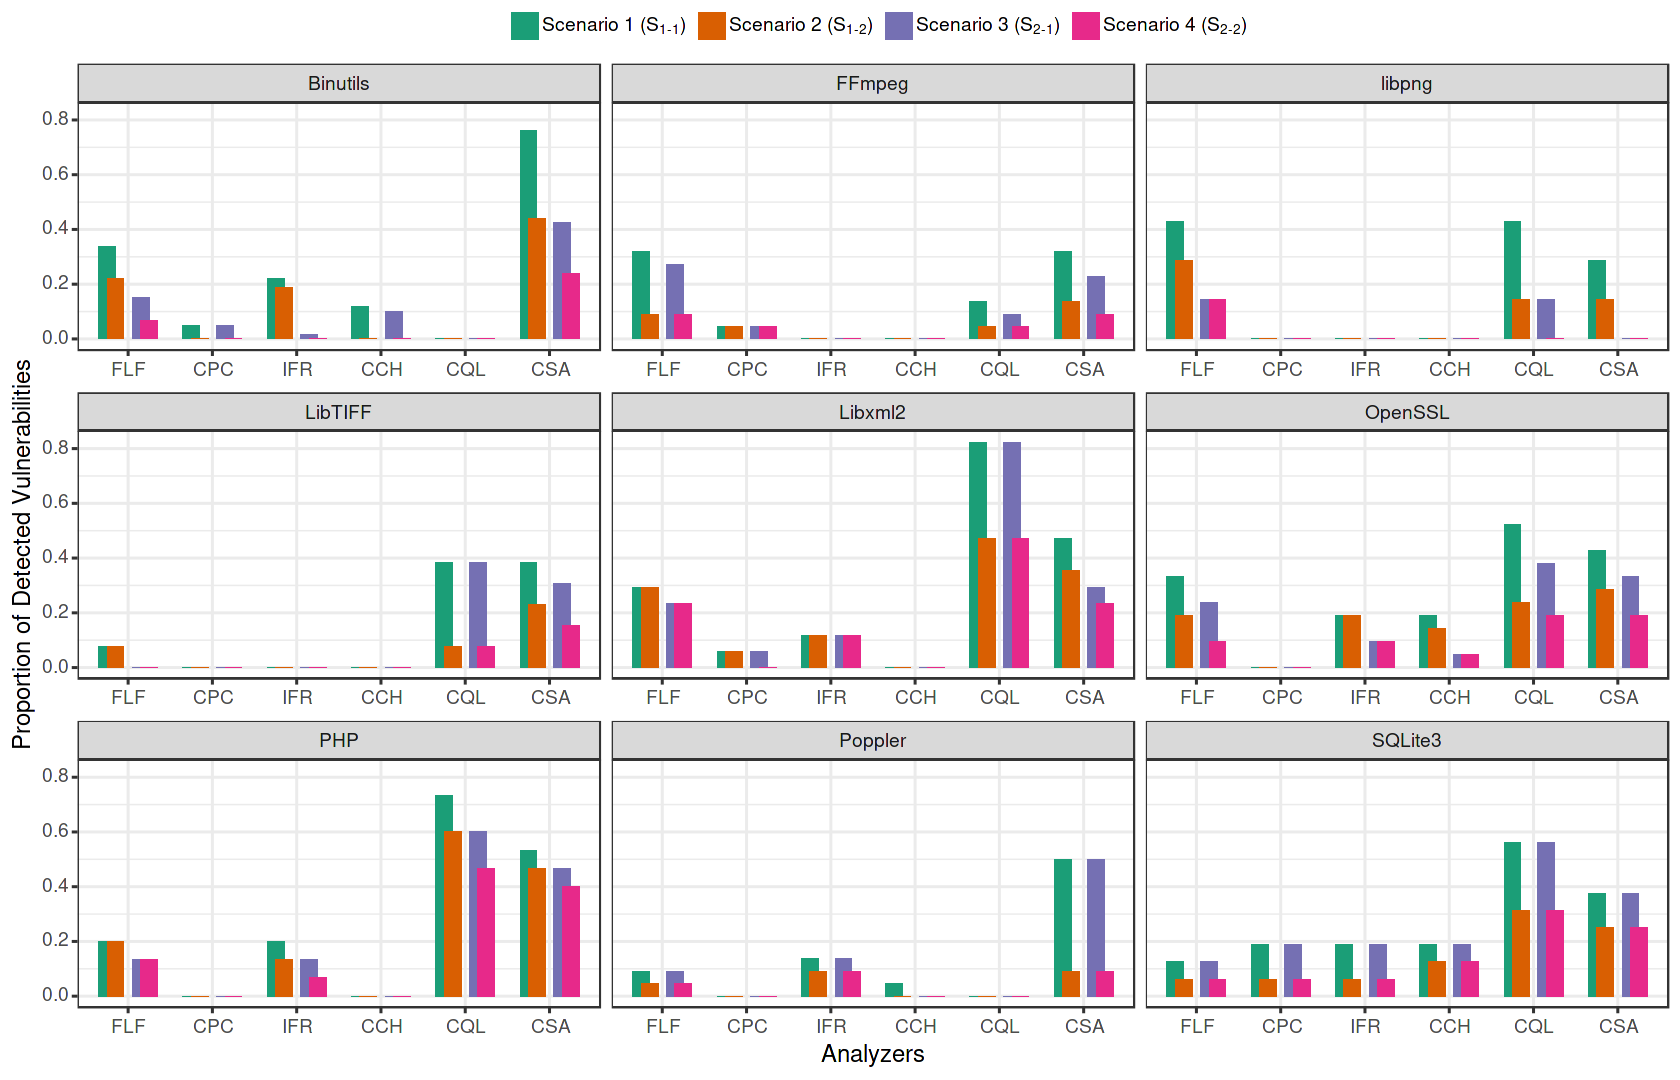

In [61]:
options(repr.plot.width = 14, repr.plot.height = 9)

ggplot() +
    labs(x = "Analyzers", y = "Proportion of Detected Vulnerabilities") +
    geom_bar(data = sca_data_1a_s1, mapping = aes(x = factor(Comb_Token, levels = analyzer_abbrevs), y = Detection_Ratio, fill = Scenario),
        stat = "identity", width = 0.2, position = position_nudge(x = -0.25)) +
    geom_bar(data = sca_data_1a_s2, mapping = aes(x = factor(Comb_Token, levels = analyzer_abbrevs), y = Detection_Ratio, fill = Scenario),
        stat = "identity", width = 0.2, position = position_nudge(x = -0.15)) +
    geom_bar(data = sca_data_1a_s3, mapping = aes(x = factor(Comb_Token, levels = analyzer_abbrevs), y = Detection_Ratio, fill = Scenario),
        stat = "identity", width = 0.2, position = position_nudge(x = 0.15)) +
    geom_bar(data = sca_data_1a_s4, mapping = aes(x = factor(Comb_Token, levels = analyzer_abbrevs), y = Detection_Ratio, fill = Scenario),
        stat = "identity", width = 0.2, position = position_nudge(x = 0.25)) +
    scale_fill_brewer(labels = scenario_exprs, palette = "Dark2") +
    facet_wrap(.~Target, scales = "free_x", nrow = 3) +
    theme(legend.position = "top", legend.title = element_blank())

ggsave("fig3.pdf", width = 14, height = 9)

options(repr.plot.width = 10, repr.plot.height = 6)

In [62]:
fct_stats_2 = read.csv("fct_stats_2.csv") %>%
    group_by(Analyzer_Comb, Comb_Token)   %>%
    summarise(Sum.N_Marked_Fcts = sum(N_Marked_Fcts),
              Sum.N_All_Fcts    = sum(N_All_Fcts)) %>% ungroup() %>%
    mutate(Ratio_Marked_Fcts = Sum.N_Marked_Fcts / Sum.N_All_Fcts)

head(fct_stats_2)

`summarise()` has grouped output by 'Analyzer_Comb'. You can override using the
`.groups` argument.


Analyzer_Comb,Comb_Token,Sum.N_Marked_Fcts,Sum.N_All_Fcts,Ratio_Marked_Fcts
<chr>,<chr>,<int>,<int>,<dbl>
codechecker,CCH,726,55203,0.01315146
codechecker-commsca,CCH-CSA,8815,55203,0.15968335
codeql,CQL,8736,55203,0.15825227
codeql-codechecker,CQL-CCH,9235,55203,0.16729163
codeql-codechecker-commsca,CQL-CCH-CSA,14101,55203,0.25543902
codeql-commsca,CQL-CSA,13738,55203,0.24886329


In [63]:
sca_data_1b = sca_data_1 %>%
    group_by(Analyzer_Comb, Comb_Token, Scenario, Comb_Length, Comb_Token_MD) %>%
    summarise(Sum.N_Detected_CVEs = sum(N_Detected_CVEs),
              Sum.N_All_CVEs      = sum(N_All_CVEs)) %>% ungroup() %>%
    mutate(Detection_Ratio = Sum.N_Detected_CVEs / Sum.N_All_CVEs) %>%
    merge(fct_stats_2, by  = "Comb_Token")

head(sca_data_1b)

`summarise()` has grouped output by 'Analyzer_Comb', 'Comb_Token', 'Scenario',
'Comb_Length'. You can override using the `.groups` argument.


,Comb_Token,Analyzer_Comb.x,Scenario,Comb_Length,Comb_Token_MD,Sum.N_Detected_CVEs,Sum.N_All_CVEs,Detection_Ratio,Analyzer_Comb.y,Sum.N_Marked_Fcts,Sum.N_All_Fcts,Ratio_Marked_Fcts
,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<int>,<dbl>
1,CCH,codechecker,Scenario 1 (S.1-1),1,CCH,15,192,0.07812500,codechecker,726,55203,0.01315146
2,CCH,codechecker,Scenario 2 (S.1-2),1,CCH,5,192,0.02604167,codechecker,726,55203,0.01315146
3,CCH,codechecker,Scenario 3 (S.2-1),1,CCH,10,192,0.05208333,codechecker,726,55203,0.01315146
4,CCH,codechecker,Scenario 4 (S.2-2),1,CCH,3,192,0.01562500,codechecker,726,55203,0.01315146
5,CCH-CSA,codechecker-commsca,Scenario 1 (S.1-1),2,CCH-**CSA**,108,192,0.56250000,codechecker-commsca,8815,55203,0.15968335
6,CCH-CSA,codechecker-commsca,Scenario 2 (S.1-2),2,CCH-**CSA**,60,192,0.31250000,codechecker-commsca,8815,55203,0.15968335


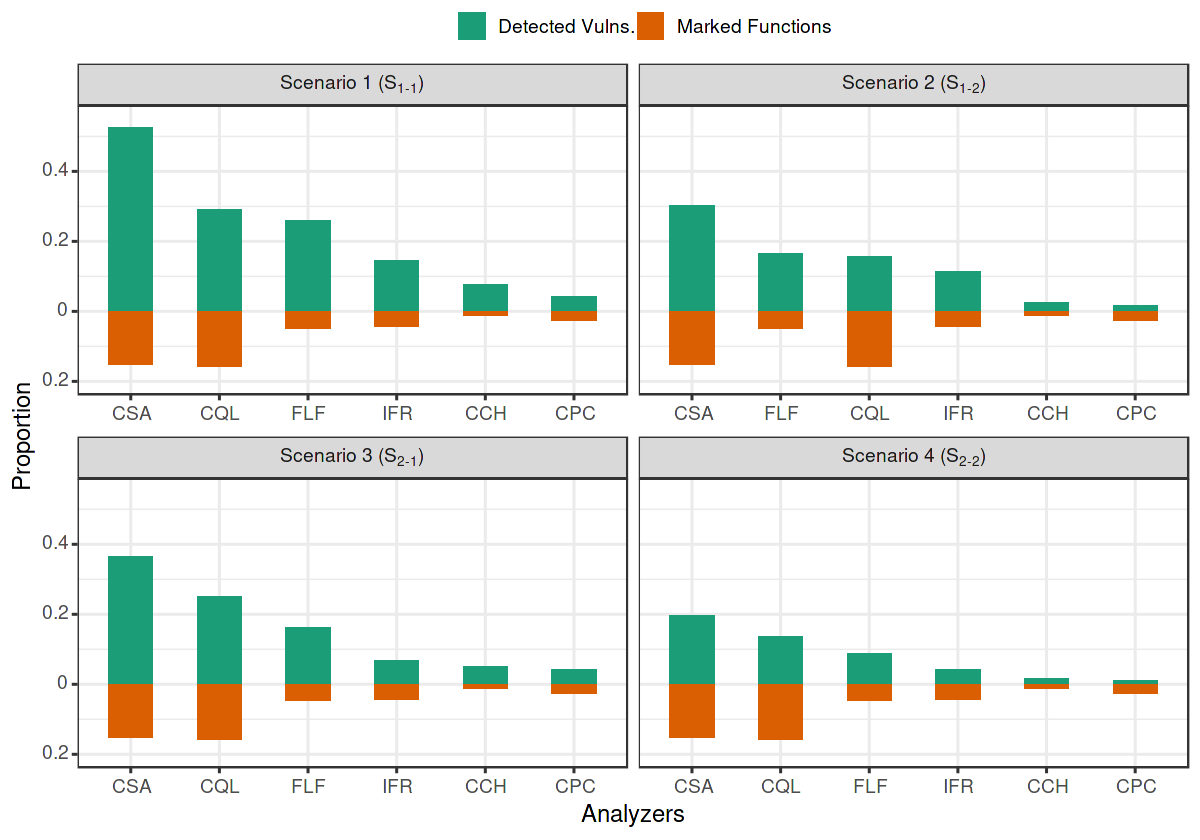

In [64]:
options(repr.plot.width = 10, repr.plot.height = 7)

ggplot(subset(sca_data_1b, is.element(Comb_Token, analyzer_abbrevs)), aes(x = reorder_within(Comb_Token, -Detection_Ratio, Scenario), y = Detection_Ratio)) +
    labs(x = "Analyzers", y = "Proportion") +
    facet_wrap(.~Scenario, labeller = labeller(Scenario = as_labeller(scenario_exprs_str, label_parsed)), scale = "free_x", nrow = 2) +
    geom_col(aes(fill = "Detected Vulns."), width = 0.5) +
    geom_col(aes(fill = "Marked Functions", y = -Ratio_Marked_Fcts), width = 0.5) +
    scale_x_reordered() +
    scale_y_continuous(labels = function (x) abs(x), limits = c(-0.2, 0.55)) +
    scale_fill_brewer(palette = "Dark2") +
    theme(legend.position = "top", legend.title = element_blank())

ggsave("fig4.pdf", width = 10, height = 7)

options(repr.plot.width = 10, repr.plot.height = 6)

### RQ.2: Effectiveness Increase by Analyzer Combinations

In [65]:
# Extracts the most effective combinations of static analyzers
sca_data_1b %>%
    mutate(Comb_Type = ifelse(!grepl("CSA", Comb_Token), "Free & Open-Source (FOS)", "FOS + Commercial")) %>%
    arrange(desc(Detection_Ratio), Comb_Length)  %>%
    group_by(Comb_Type, Scenario) %>% slice(1:1) %>%
    select(Comb_Type, Scenario, Comb_Token)

Comb_Type,Scenario,Comb_Token
<chr>,<chr>,<chr>
FOS + Commercial,Scenario 1 (S.1-1),FLF-IFR-CQL-CCH-CSA
FOS + Commercial,Scenario 2 (S.1-2),FLF-CPC-IFR-CQL-CSA
FOS + Commercial,Scenario 3 (S.2-1),FLF-IFR-CQL-CCH-CSA
FOS + Commercial,Scenario 4 (S.2-2),FLF-CPC-IFR-CQL-CSA
Free & Open-Source (FOS),Scenario 1 (S.1-1),FLF-CPC-IFR-CQL-CCH
Free & Open-Source (FOS),Scenario 2 (S.1-2),FLF-CPC-IFR-CQL-CCH
Free & Open-Source (FOS),Scenario 3 (S.2-1),FLF-CPC-IFR-CQL-CCH
Free & Open-Source (FOS),Scenario 4 (S.2-2),FLF-CPC-IFR-CQL-CCH


In [66]:
get_best_combs  = function(sca_data) {
    sca_free_s1 = list("CQL", "FLF-CPC-IFR-CQL-CCH")
    sca_free_s2 = list("FLF", "FLF-CPC-IFR-CQL-CCH")
    sca_free_s3 = list("CQL", "FLF-CPC-IFR-CQL-CCH")
    sca_free_s4 = list("CQL", "FLF-CPC-IFR-CQL-CCH")
    
    sca_comm_s1 = list("CSA", "FLF-IFR-CQL-CCH-CSA")
    sca_comm_s2 = list("CSA", "FLF-CPC-IFR-CQL-CSA")
    sca_comm_s3 = list("CSA", "FLF-IFR-CQL-CCH-CSA")
    sca_comm_s4 = list("CSA", "FLF-CPC-IFR-CQL-CSA")
    
    sca_data_free_s1 = filter(sca_data, Scenario == "Scenario 1 (S.1-1)") %>%
        filter(Comb_Token %in% sca_free_s1)
    sca_data_free_s2 = filter(sca_data, Scenario == "Scenario 2 (S.1-2)") %>%
        filter(Comb_Token %in% sca_free_s2)
    sca_data_free_s3 = filter(sca_data, Scenario == "Scenario 3 (S.2-1)") %>%
        filter(Comb_Token %in% sca_free_s3)
    sca_data_free_s4 = filter(sca_data, Scenario == "Scenario 4 (S.2-2)") %>%
        filter(Comb_Token %in% sca_free_s4)
    
    sca_data_comm_s1 = filter(sca_data, Scenario == "Scenario 1 (S.1-1)") %>%
        filter(Comb_Token %in% sca_comm_s1)
    sca_data_comm_s2 = filter(sca_data, Scenario == "Scenario 2 (S.1-2)") %>%
        filter(Comb_Token %in% sca_comm_s2)
    sca_data_comm_s3 = filter(sca_data, Scenario == "Scenario 3 (S.2-1)") %>%
        filter(Comb_Token %in% sca_comm_s3)
    sca_data_comm_s4 = filter(sca_data, Scenario == "Scenario 4 (S.2-2)") %>%
        filter(Comb_Token %in% sca_comm_s4)
    
    return(
        rbind(
            rbind(
                sca_data_free_s1,
                sca_data_free_s2,
                sca_data_free_s3,
                sca_data_free_s4
            ),
            rbind(
                sca_data_comm_s1,
                sca_data_comm_s2,
                sca_data_comm_s3,
                sca_data_comm_s4
            )
        )
    )
}

In [67]:
(sca_data_1c = get_best_combs(sca_data_1b))

Comb_Token,Analyzer_Comb.x,Scenario,Comb_Length,Comb_Token_MD,Sum.N_Detected_CVEs,Sum.N_All_CVEs,Detection_Ratio,Analyzer_Comb.y,Sum.N_Marked_Fcts,Sum.N_All_Fcts,Ratio_Marked_Fcts
<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<int>,<dbl>
CQL,codeql,Scenario 1 (S.1-1),1,CQL,56,192,0.2916667,codeql,8736,55203,0.15825227
FLF-CPC-IFR-CQL-CCH,flawfinder-cppcheck-infer-codeql-codechecker,Scenario 1 (S.1-1),5,FLF-CPC-IFR-CQL-CCH,101,192,0.5260417,flawfinder-cppcheck-infer-codeql-codechecker,13446,55203,0.24357372
FLF,flawfinder,Scenario 2 (S.1-2),1,FLF,32,192,0.1666667,flawfinder,2628,55203,0.04760611
FLF-CPC-IFR-CQL-CCH,flawfinder-cppcheck-infer-codeql-codechecker,Scenario 2 (S.1-2),5,FLF-CPC-IFR-CQL-CCH,63,192,0.3281250,flawfinder-cppcheck-infer-codeql-codechecker,13446,55203,0.24357372
CQL,codeql,Scenario 3 (S.2-1),1,CQL,48,192,0.2500000,codeql,8736,55203,0.15825227
FLF-CPC-IFR-CQL-CCH,flawfinder-cppcheck-infer-codeql-codechecker,Scenario 3 (S.2-1),5,FLF-CPC-IFR-CQL-CCH,79,192,0.4114583,flawfinder-cppcheck-infer-codeql-codechecker,13446,55203,0.24357372
CQL,codeql,Scenario 4 (S.2-2),1,CQL,26,192,0.1354167,codeql,8736,55203,0.15825227
FLF-CPC-IFR-CQL-CCH,flawfinder-cppcheck-infer-codeql-codechecker,Scenario 4 (S.2-2),5,FLF-CPC-IFR-CQL-CCH,42,192,0.2187500,flawfinder-cppcheck-infer-codeql-codechecker,13446,55203,0.24357372
CSA,commsca,Scenario 1 (S.1-1),1,**CSA**,101,192,0.5260417,commsca,8359,55203,0.15142293


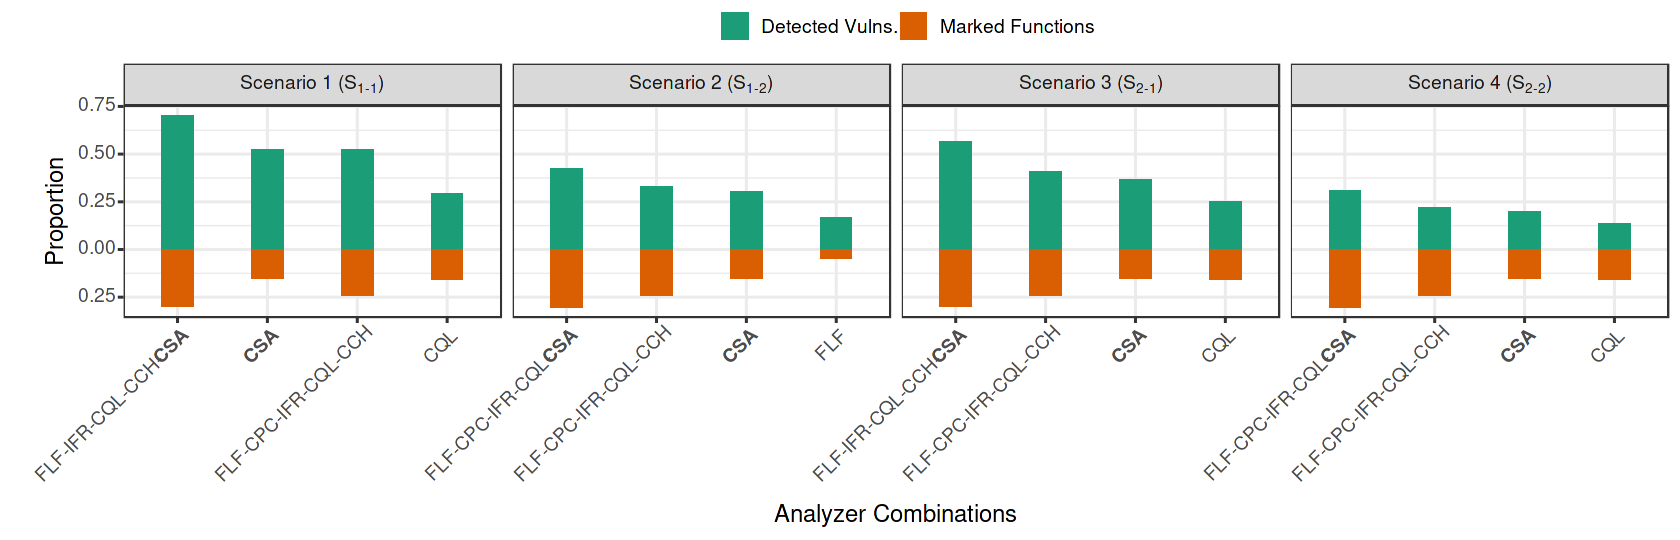

In [68]:
options(repr.plot.width = 14, repr.plot.height = 4.5)

ggplot(sca_data_1c, aes(x = reorder_within(Comb_Token_MD, -Detection_Ratio, Scenario), y = Detection_Ratio)) +
    labs(x = "Analyzer Combinations", y = "Proportion") +
    facet_wrap(.~Scenario, labeller = labeller(Scenario = as_labeller(scenario_exprs_str, label_parsed)), scales = "free_x", nrow = 1) +
    geom_col(aes(fill = "Detected Vulns."), width = 0.35) +
    geom_col(aes(fill = "Marked Functions", y = -Ratio_Marked_Fcts), width = 0.35) +
    scale_x_reordered() +
    scale_y_continuous(labels = function (x) format(round(abs(x), 2), nsmall = 2)) +
    scale_fill_brewer(palette = "Dark2") +
    theme(legend.position = "top", legend.title = element_blank()) +
    theme(axis.title.x = element_markdown(margin = margin(t = 10)),
          axis.title.y = element_markdown(margin = margin(l = 20, r = 5))) +
    theme(axis.text.x  = element_markdown(angle = 45, vjust = 1, hjust = 1))

ggsave("fig5.pdf", width = 14, height = 4.5)

options(repr.plot.width = 10, repr.plot.height = 6)

### RQ.3: Best vs. Worst Detected Vulnerabilities

In [69]:
sca_data_2 = read.csv("sca_data_2.csv") %>%
    group_by(Analyzer_Comb, Comb_Token, Scenario, HL_CWE_ID) %>%
    summarise(Sum.N_Detected_CVEs = sum(N_Detected_CVEs),
              Sum.N_All_CVEs      = sum(N_All_CVEs))

head(sca_data_2)

`summarise()` has grouped output by 'Analyzer_Comb', 'Comb_Token', 'Scenario'.
You can override using the `.groups` argument.


Analyzer_Comb,Comb_Token,Scenario,HL_CWE_ID,Sum.N_Detected_CVEs,Sum.N_All_CVEs
<chr>,<chr>,<chr>,<int>,<int>,<int>
codechecker,CCH,Scenario 1 (S.1-1),664,6,117
codechecker,CCH,Scenario 1 (S.1-1),682,2,27
codechecker,CCH,Scenario 1 (S.1-1),691,1,7
codechecker,CCH,Scenario 1 (S.1-1),703,5,29
codechecker,CCH,Scenario 1 (S.1-1),707,1,12
codechecker,CCH,Scenario 2 (S.1-2),664,1,117


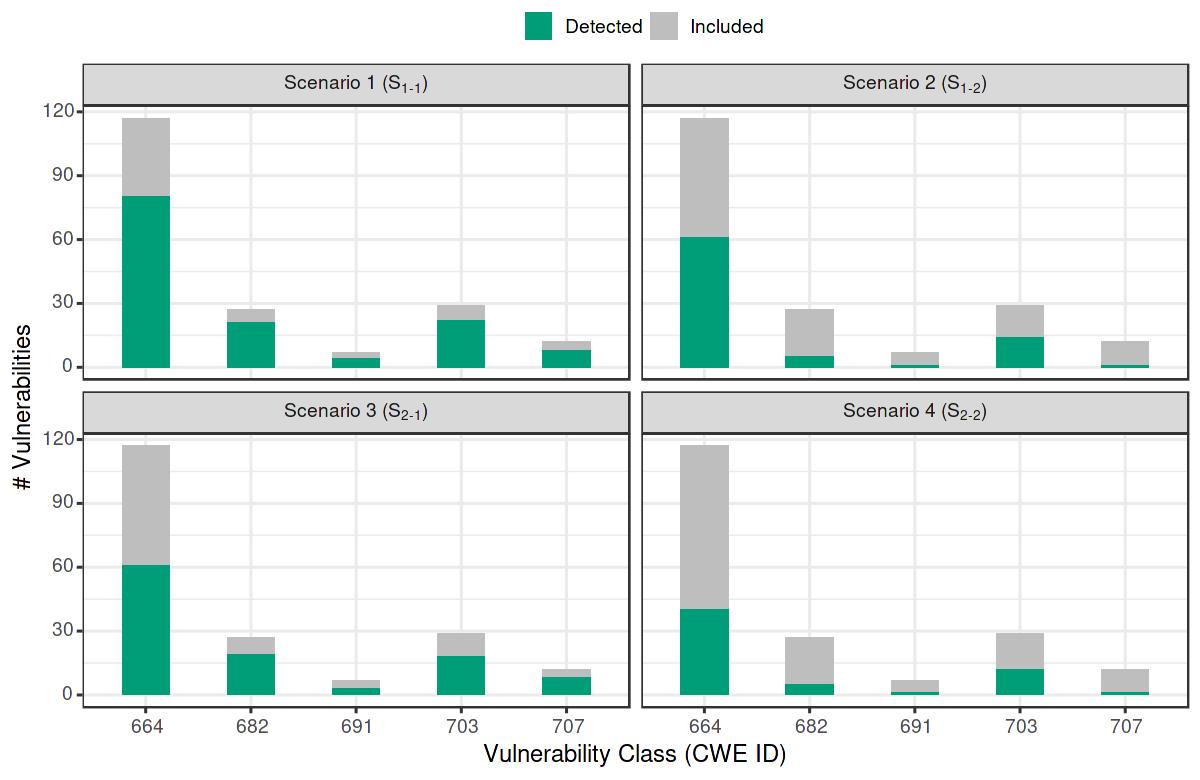

In [70]:
options(repr.plot.width = 10, repr.plot.height = 6.5)

sca_data_2 %>%
    filter(Comb_Token == "FLF-CPC-IFR-CQL-CCH-CSA") %>%
    ggplot(aes(x = factor(HL_CWE_ID, levels = c(664, 682, 691, 703, 707)))) +
        labs(x = "Vulnerability Class (CWE ID)", y = "# Vulnerabilities") +
        facet_wrap(.~Scenario, labeller = labeller(Scenario = as_labeller(scenario_exprs_str, label_parsed)), nrow = 2) +
        geom_bar(aes(y = Sum.N_All_CVEs, fill = "Included"), stat = "identity", width = 0.45) +
        geom_bar(aes(y = Sum.N_Detected_CVEs, fill = "Detected"), stat = "identity", width = 0.45) +
        scale_fill_manual(values = c("#009e78", "grey")) +
        theme(legend.position = "top", legend.title = element_blank())

ggsave("fig6.pdf", width = 10, height = 6.5)

options(repr.plot.width = 10, repr.plot.height = 6)